###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `PLEASE ENTER YOUR ID(S) HERE`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [9]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(train_file_name, test_file_name):
    # put data into dataframes, remove the first column (filename)
    return pd.read_csv(train_file_name).iloc[:,1:], pd.read_csv(test_file_name).iloc[:,1:]

In [10]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model
""" Calculate the prior probability of all the class labels for the naive bayes
    model. The argument of the function is the train dataframe and the output
    is a dictionary containing the prior probabilities of each label """
def calculate_prior_prob(train_df : pd.DataFrame):
    prior_prob = {}
    label_instances = train_df["label"]
    labels = np.unique(label_instances)
    total_instances = label_instances.count()
    
    # iterate over all the labels and calculate the prior probabilities
    for label in labels:
        label_count = (label_instances == label).sum()
        prior_prob[label] = label_count / total_instances

    return prior_prob

""" Calculate the parameters of a Gaussian distribution for likelihood 
    probabilities of all the features in the dataset conditional on the class 
    label for the model. The argument of the function is the train dataframe 
    and the output is a 2D dictionary containing the means and 
    standard deviations
    """
def calculate_gaussian_parameters(train_df : pd.DataFrame):
    gaussian_parameters = {}
    features = train_df.columns[:-1]
    label_instances = train_df["label"]
    labels = np.unique(label_instances)

    # iterate over each feature and then each label
    for feature in features:
        gaussian_parameters[feature] = {}
        feature_label_instances = train_df[[feature, "label"]]

        for label in labels:
            label_count = (label_instances == label).sum()

            # get all the feature values that have the label and compute the
            # mean and standard deviation
            values_in_label = feature_label_instances[(label_instances == label)]
            likelihood_mean = values_in_label[feature].sum() / label_count
            likelihood_sd = np.sqrt(values_in_label[feature].apply(lambda x: (x - likelihood_mean)**2).sum() / (label_count - 1))
            gaussian_parameters[feature][label] = (likelihood_mean, likelihood_sd)

    return gaussian_parameters

""" Probability density function of the Gaussian distribution. Takes the mean,
    standard deviation and x_value and returns the value of the density function 
    at the x_value. If take_log argument is true, return the log of 
    the density value """
def gaussian_pdf(mean, sd, x_value, take_log = False):
    if take_log:
        return -(x_value - mean)**2/(2*sd**2) - np.log(sd*np.sqrt(2*np.pi))
    else:
        return (1/sd*np.sqrt(2*np.pi))*np.exp(-(x_value - mean)**2/(2*sd**2))

def train(train_df):
    return calculate_prior_prob(train_df), calculate_gaussian_parameters(train_df)


In [11]:
# Naive Bayes Model Application

# Predicts class for a test instance
def predict_instance(instance, priors, likelihood_pdf, likelihood_pdf_parameters):    
    labels = likelihood_pdf_parameters[likelihood_pdf_parameters.keys()[0]].keys()
    best, best_score = [], 0
    for label in labels:
        # Calculate the best score for the current class label
        score = 0
        for feature in instance[instance.notnull()].index:
            score += likelihood_pdf(instance[feature], likelihood_pdf, likelihood_pdf_parameters)
        # Keep track of the best class labels
        if score > best_score:
            best = [label]
            best_score = score
        elif score == best_score:
            best.append(label)
    
# Predicts classes for each instance in the test dataset
def predict(test_df, priors, likelihood_pdf, likelihood_pdf_parameters):    
    return test_df.apply(lambda instance: predict_instance(instance, priors, likelihood_pdf, likelihood_pdf_parameters))

In [12]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

"""
    The first argument should be a series which contains the true labels of a test set.
    The second argument should be a series which contains predicted labels of the same test set."""
def evaluate(true_labels, predicted_labels, positive_label, negative_label):
    labels = [positive_label, negative_label]
    
    # Count the number of occurrences for each combination of true and predicted labels
    combination_counts = pd.concat([true_labels, predicted_labels], axis="columns", ignore_index=True).value_counts()
    
    # Set the count of any combination that wasn't seen to 0
    index = pd.MultiIndex.from_tuples(itertools.product(labels, labels), names=["true_labels", "predicted_labels"])
    confusion_matrix = combination_counts.reindex(index=index, fill_value=0)
    
    evaluation_metrics = dict()
    
    # At this point there is no ambiguity regarding the meaning of these variables... give them aliases
    m, positive, negative = confusion_matrix, positive_label, negative_label
    print(confusion_matrix)
    evaluation_metrics["accuracy"] = (m[positive, positive] + m[negative, negative]) / m.sum()
    evaluation_metrics["precision"] = m[positive, positive] / (m[positive, positive] + m[negative, positive])
    evaluation_metrics["recall"] = m[positive, positive] / (m[positive, positive] + m[positive, negative])
    evaluation_metrics["f_1"] = 2 * evaluation_metrics["precision"] * evaluation_metrics["recall"] / (evaluation_metrics["precision"] + evaluation_metrics["recall"])
    
    # TODO: more than 2 classes:
    #   - total accuracy
    #   - macro/micro/weighted averaging:
    #        - precision
    #        - recall
    #        - f1 (beta? -> what does it even do?)
    #   - per class:
    #        - precision
    #        - recall
    #        - f1 (beta? -> what does it even do?)    
    
    return evaluation_metrics

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

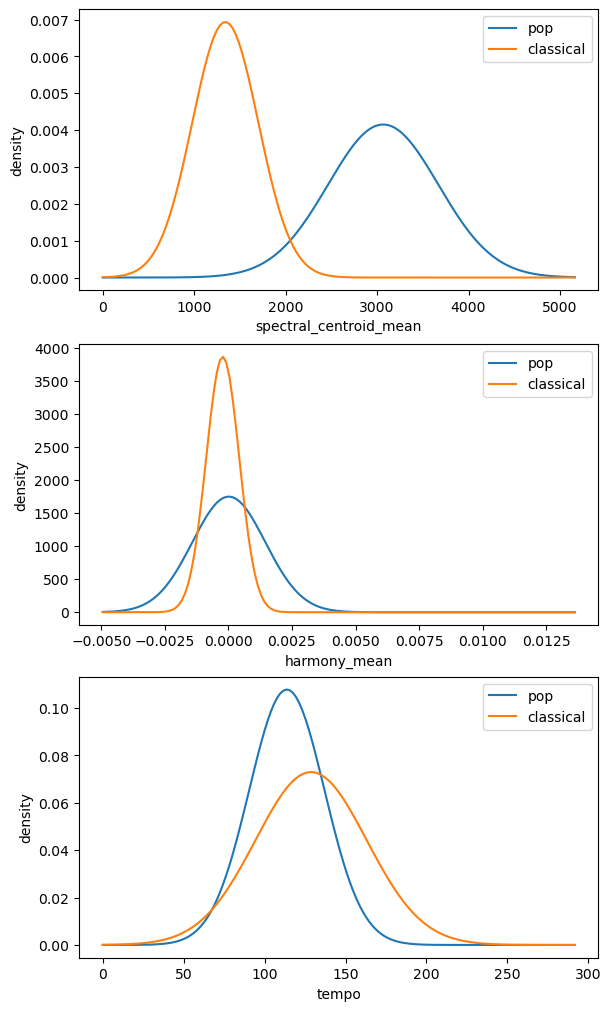

In [37]:
""" Plots the graphs of the pdf that are used for the likelihood"""
def pdf_graphs_constructor(train_df, feature, gaussian_param, ax):
    if (np.min(train_df[feature]) >= 0):
        lower =  0
    else :
        lower =  np.min(train_df[feature]) + 0.25 * np.min(train_df[feature])
    upper = np.max(train_df[feature]) + 0.25 * np.max(train_df[feature])
    x_values = np.arange(lower, upper, (upper - lower) / 150)

    # calculate the values of the pdf using the x-value for each label.
    for label in ['pop', 'classical']:
        mean = gaussian_param[feature][label][0]
        sd = gaussian_param[feature][label][1]
        y_values = np.array([gaussian_pdf(mean, sd, x, False) for x in x_values])
        ax.plot(x_values, y_values, label=label)
    ax.legend()
    ax.set_xlabel(feature)
    ax.set_ylabel('density')

#fig, axes = plt.subplots(3, 1, figsize = (6, 10),layout='constrained')
#train_df, test_df = preprocess('COMP30027_2023_asst1_data\pop_vs_classical_train.csv','COMP30027_2023_asst1_data\pop_vs_classical_test.csv')
#prior, likelihood = train(train_df)
#pdf_graphs_constructor(train_df, 'spectral_centroid_mean', likelihood, axes[0])
#pdf_graphs_constructor(train_df, 'harmony_mean', likelihood, axes[1])
#pdf_graphs_constructor(train_df, 'tempo', likelihood, axes[2])
#plt.show()



## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.